# Introduction

In [ ]:
"""
Created ob 20190206

Topic: Semantic (Image) Segmentation (圖像語義分割)

Reference:
1. 語意分割: https://www.jiqizhixin.com/articles/2018-06-04-17 (from 機器之心)
2. U-Net Intro: https://blog.csdn.net/hduxiejun/article/details/71107285
3. U-Net in Keras: https://www.depends-on-the-definition.com/unet-keras-segmenting-images/
"""

## tqdm進度條使用方法
https://blog.csdn.net/zejianli/article/details/77915751

In [1]:
import time
from tqdm import tqdm
from tqdm import trange  # 等價

for i in tqdm(range(100)):
     time.sleep(0.01)

for i in trange(100):
    time.sleep(0.01)

100%|██████████| 100/100 [00:01<00:00, 97.46it/s]


## 在jupyter notebook上使用

In [2]:
from tqdm import tnrange, tqdm_notebook
from time import sleep

for i in tqdm_notebook(range(100), desc='1st loop'):
   # for j in tnrange(100, desc='2nd loop', leave=False):
    sleep(0.01)

# Import

In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain

from sklearn.model_selection import train_test_split

import tensorflow as tf

import cv2
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

Using TensorFlow backend.


# Set parameters

In [5]:
# Set some parameters
im_width = 128
im_height = 128
border = 5
path_train = 'train'
path_test = 'test'

In [5]:
img = load_img(path_train + '/images/' + "8d08955cdf.png", grayscale=True)
img_to_array(img).shape

/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(101, 101, 1)

In [6]:
cv2.imread(path_train + '/images/' + "8d08955cdf.png", 0).shape

(101, 101)

# Load the images

In [7]:
# Get and resize train images and masks
def get_data(path, im_height=128, im_width=128, train=True):
    # files = next(os.walk(path + "images"))[2]  # walk完是([root, dirs, files])的generator。用next後取出檔案。
    files = os.listdir(path + "/images")
    X = np.zeros(shape=(len(files), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros(shape=(len(files), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, file in tqdm_notebook(enumerate(files), total=len(files)):
        # Load images
        img = cv2.imread(f"{path}/images/{file}", 0)
        x_img = cv2.resize(img, (128, 128))
#         img = load_img(path + '/images/' + file, grayscale=True)
#         x_img = img_to_array(img)
#         x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
        # Load masks
        if train:
            mask = cv2.imread(f"{path}/masks/{file}", 0)
            mask = cv2.resize(mask, (128, 128))
#             mask = img_to_array(load_img(path + '/masks/' + file, grayscale=True))
#             mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n] = np.expand_dims(x_img.squeeze() / 255, axis=2)
        if train:
            y[n] = np.expand_dims(mask / 255, axis=2)
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)
print("X shape", X.shape)
print("y shape", y.shape)

Getting and resizing images ... 



Done!
X shape (4000, 128, 128, 1)
y shape (4000, 128, 128, 1)


In [9]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

X_train shape (3400, 128, 128, 1)
y_train shape (3400, 128, 128, 1)


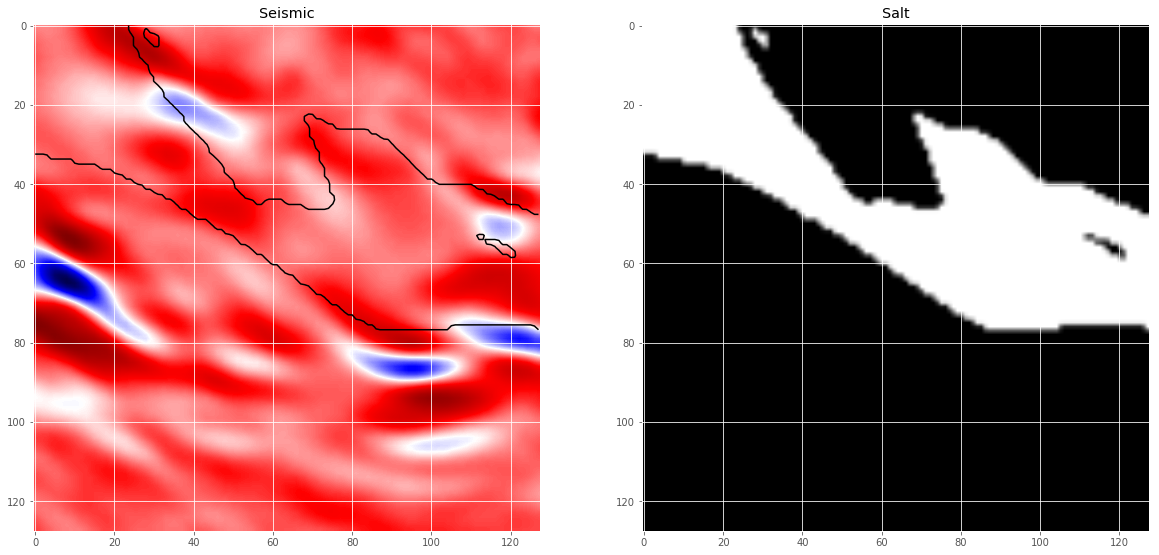

In [11]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');


# The U-Net Model
A successfull and popular model for these kind of problems is the UNet architecture. The network architecture is illustrated in Figure 1. It consists of a **contracting path (left side)** and an **expansive path (right side).**

<img src="./U-Net_model.png">

- The **contracting path** follows the typical architecture of a convolutional network. It consists of the repeated application of `two 3×3 convolutions`, each followed by `a batchnormalization layer` and a `rectified linear unit (ReLU) activation` and `dropout` and `a 2×2 max pooling operation with stride 2 for downsampling`. At each downsampling step we `double the number of feature channels`. The purpose of this contracting path is to capture the context of the input image in order to be able to do segmentation.
- Every step in the **expansive path** consists of an `upsampling of the feature map` followed by a `2×2 convolution (“up-convolution”)` that `halves the number of feature channels`, `a concatenation with the correspondingly feature map from the contracting path`, and `two 3×3 convolutions, each followed by batchnorm, dropout and a ReLU`. The purpose of this expanding path is to enable precise localization combined with contextual information from the contracting path.
- At the final layer a 1×1 convolution is used to map each 16- component feature vector to the desired number of classes.

In [14]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    out = Activation("relu")(x)
    return out

In [12]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    """
    contracting path
    """
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm) # 128, 128 ,16
    p1 = MaxPooling2D((2, 2))(c1)  # 64, 64, 16
    p1 = Dropout(dropout*0.5)(p1)  # 64, 64, 16
    # double the feature channels
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)  # 64, 64, 32
    p2 = MaxPooling2D((2, 2))(c2)  # 32, 32, 32
    p2 = Dropout(dropout)(p2)  # 32, 32, 32

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)  # 32, 32, 64
    p3 = MaxPooling2D((2, 2))(c3)  # 16, 16, 64
    p3 = Dropout(dropout)(p3)  # 16, 16, 64

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)  # 16, 16,128
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)  # 8, 8, 128
    p4 = Dropout(dropout)(p4)  # 8, 8, 128
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)  # 8, 8, 256
    """
    expansive path
    """
    # 先接反卷積長寬2倍回來
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)  # 16, 16, 128
    # 再將Conv2D的卷積input疊回來
    u6 = concatenate([u6, c4])  # 16, 16, 256 (c4: 16, 16, 128)
    u6 = Dropout(dropout)(u6)  # 16, 16, 256
    # 每一次反卷積疊完還要再一次卷積，跟之前兩層卷積一樣，把高減回來好concat
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)  # 16, 16, 128

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)  # 32, 32, 64
    u7 = concatenate([u7, c3])  # 32, 32, 128
    u7 = Dropout(dropout)(u7)  # 32, 32, 128
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)  # 32, 32, 64

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)  # 64, 64, 32
    u8 = concatenate([u8, c2])  # 64, 64, 64
    u8 = Dropout(dropout)(u8)  # 64, 64, 64
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)  # 64, 64, 32

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)  # 128, 128, 16
    u9 = concatenate([u9, c1], axis=3)  # 128, 128, 32 (concatenate都是疊feature channel維，這邊打出來提醒一下)
    u9 = Dropout(dropout)(u9)  # 128, 128, 32
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)  # 128, 128, 16
    
    outputs = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(c9)  # 128, 128, 1
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## Compile

In [15]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

W0501 20:59:44.243645 140142594889536 deprecation.py:237] From /home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0501 20:59:44.381866 140142594889536 deprecation.py:506] From /home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tensorflow/python/training/moving_averages.py:211: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0501 20:59:44.722627 140142594889536 deprecation.py:506] From /home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instruc

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
# 放個callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

## Start training

In [12]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/100
3400/3400 [==============================] - 471s 138ms/step - loss: 0.4329 - acc: 0.8223 - val_loss: 0.4188 - val_acc: 0.8738

Epoch 00001: val_loss improved from inf to 0.41876, saving model to model-tgs-salt.h5
Epoch 2/100
3400/3400 [==============================] - 465s 137ms/step - loss: 0.3037 - acc: 0.8863 - val_loss: 0.4569 - val_acc: 0.8406

Epoch 00002: val_loss did not improve from 0.41876
Epoch 3/100
3400/3400 [==============================] - 465s 137ms/step - loss: 0.2689 - acc: 0.8981 - val_loss: 0.3956 - val_acc: 0.8714

Epoch 00003: val_loss improved from 0.41876 to 0.39560, saving model to model-tgs-salt.h5
Epoch 4/100
3400/3400 [==============================] - 465s 137ms/step - loss: 0.2542 - acc: 0.8989 - val_loss: 0.2725 - val_acc: 0.8936

Epoch 00004: val_loss improved from 0.39560 to 0.27251, saving model to model-tgs-salt.h5
Epoch 5/100
3400/3400 [==============================] - 465s 137ms/step - l

## Visualize the result

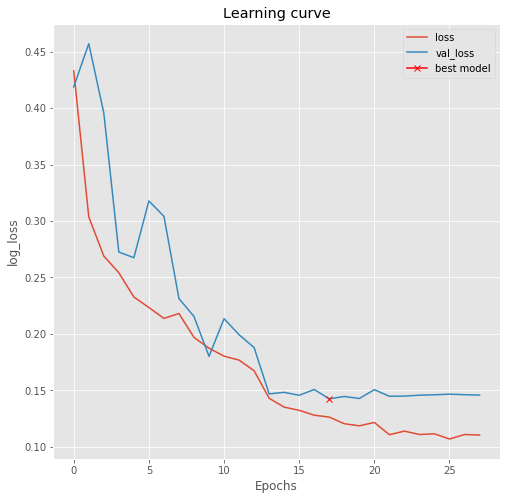

In [13]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

# Inference With The Model

In [16]:
# Load best model
model.load_weights('model-tgs-salt.h5')

In [17]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

600/600 [==============================] - 15s 25ms/step


[0.14257855097452798, 0.9440908821423849]

In [18]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

600/600 [==============================] - 14s 23ms/step


In [20]:
# 預測圖像是不是包含物體 by pixels (每一個pixel都是一個binary classification機率)
print(preds_train[0])
print(preds_train_t[0])

[[[0.4628558 ]
  [0.47568145]
  [0.5519062 ]
  ...
  [0.05633283]
  [0.06483766]
  [0.17425254]]

 [[0.45588604]
  [0.4891782 ]
  [0.5126711 ]
  ...
  [0.05778047]
  [0.06027749]
  [0.09121555]]

 [[0.50569814]
  [0.5156699 ]
  [0.51958144]
  ...
  [0.15137616]
  [0.15170923]
  [0.1242519 ]]

 ...

 [[0.38524076]
  [0.38214195]
  [0.3756391 ]
  ...
  [0.07751557]
  [0.07781145]
  [0.08160532]]

 [[0.28265768]
  [0.37712476]
  [0.36164832]
  ...
  [0.08945504]
  [0.10835561]
  [0.08436221]]

 [[0.33174694]
  [0.3423457 ]
  [0.41458613]
  ...
  [0.08295429]
  [0.10624203]
  [0.10616186]]]
[[[0]
  [0]
  [1]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [1]
  ...
  [0]
  [0]
  [0]]

 [[1]
  [1]
  [1]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


`An important step we skip here is to select an appropriate threshold for the model. This is normaly done by optimizing the threshold on a holdout set. Let’s look at some predictions.`

In [21]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))
    # mask就是那個鹽所在區域的輪廓
    has_mask = y[ix].max() > 0
    # numpy.squeeze() -> Remove single-dimensional entries from the shape of an array.
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')  # X只剩下兩維
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])  # squeeze把所有維度是1的拿掉
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')
    
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary')

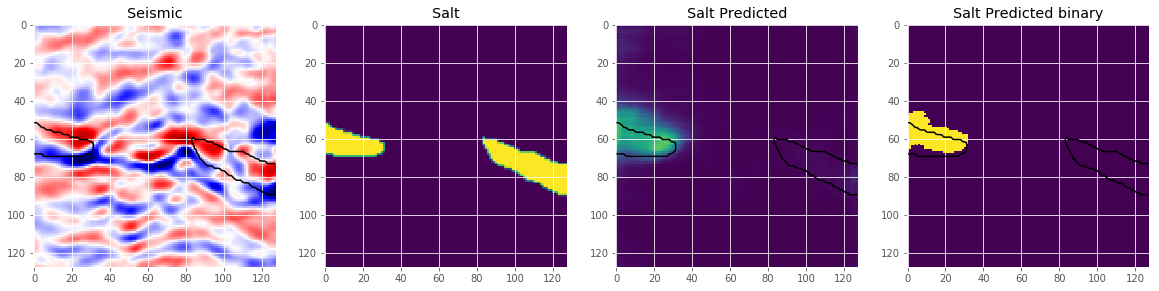

In [22]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

In [22]:
preds_val[19].squeeze().shape

(128, 128)

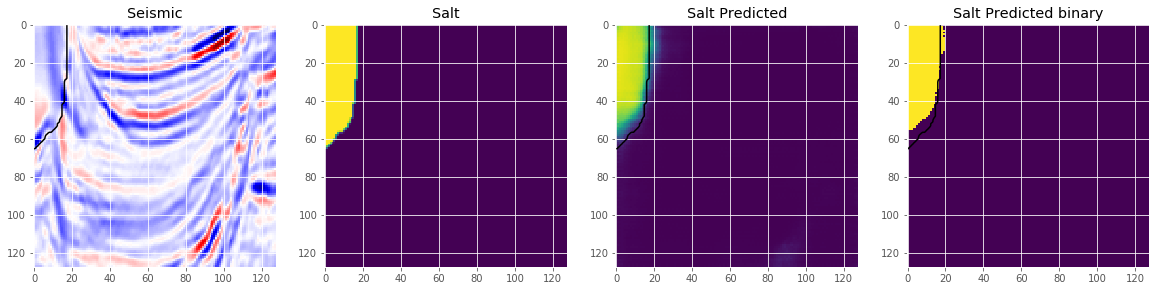

In [26]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

- This looks like we are going in the right direction, but obviously there is space left to improve. But that’s it for now. Now you can use the model to predict on the test images and submit your predictions to the competition. **If you use an appropriate method to choose the threshold, this should give you a score around 0.7 on the learderboard.**

- I hope you enjoyed this post and learned something. Join the competition and try the model yourself. In the next post, I will show you how to **improve the model with data augmentation and test time augmentation.**